Notebook for 02. Classification

1. Make classification data and get it ready

In [7]:
import sklearn

In [8]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples=n_samples, 
                    noise=0.03,
                    random_state=42)

In [9]:
X.shape

(1000, 2)

In [10]:
# Make DataFrame of circle data

import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], 
                        "X2": X[:, 1], 
                        "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


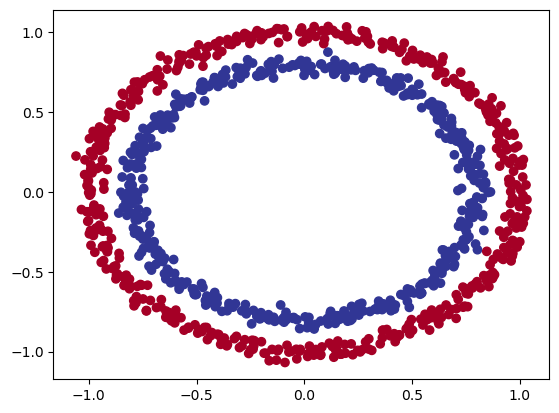

In [11]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [12]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [13]:
import torch
torch.__version__

'2.2.1'

In [14]:
# Convert to PyTorch tensors

X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

In [15]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Check the shapes

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [17]:
# Build a model
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

# Move data to the device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [18]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))

model0 = CircleModelV0().to(device)

model0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
# Replicate code using nn.Sequential

model0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
model0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.4469, -0.4248],
                      [-0.0957, -0.4594],
                      [-0.4346,  0.3958],
                      [ 0.1256, -0.2547],
                      [ 0.4919,  0.0463]], device='cuda:0')),
             ('0.bias',
              tensor([-0.4648,  0.5897, -0.5894,  0.5300, -0.5991], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.3763,  0.0746, -0.3798, -0.1004, -0.0657]], device='cuda:0')),
             ('1.bias', tensor([0.3233], device='cuda:0'))])

In [21]:
with torch.inference_mode():   
    untrained_preds = model0(X_train)


In [22]:
print(torch.round(untrained_preds[:10]))

tensor([[1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.],
        [1.]], device='cuda:0')


In [23]:
#Setup loss function and optimizer

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(model0.parameters(), lr=0.1)

In [24]:
# Calculate accuracy
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred) * 100)
    return acc


In [25]:
# Build a training loop

model0.eval()

with torch.inference_mode():

    y_logits = model0(X_test)[:5]

y_pred = torch.round(torch.sigmoid(y_logits))  

print(torch.eq(y_pred.squeeze(), y_test[:5]))
y_pred.squeeze()

tensor([ True, False,  True, False,  True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0')

In [26]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set epochs
epochs = 1000

# Build training and evaluation loops
for epoch in range(epochs):
    # Set model to training mode
    model0.train()

    # Forward pass
    y_logits = model0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Calculate loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy(y_train, y_pred)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Optimizer step
    optimizer.step()

    #Testing
    model0.eval()
    with torch.inference_mode():
        test_logits = model0(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        # Loss
        test_loss = loss_fn(test_logits, y_test)

        # Accuracy
        test_acc = accuracy(y_test, test_preds)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train Loss: {loss:.4f}, Train Acc: {acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    


Epoch 0: Train Loss: 0.7239, Train Acc: 55.00%, Test Loss: 0.7131, Test Acc: 59.00%
Epoch 10: Train Loss: 0.7052, Train Acc: 51.62%, Test Loss: 0.6998, Test Acc: 56.50%
Epoch 20: Train Loss: 0.6998, Train Acc: 50.62%, Test Loss: 0.6965, Test Acc: 53.00%
Epoch 30: Train Loss: 0.6977, Train Acc: 50.50%, Test Loss: 0.6955, Test Acc: 51.00%
Epoch 40: Train Loss: 0.6966, Train Acc: 50.75%, Test Loss: 0.6950, Test Acc: 47.50%
Epoch 50: Train Loss: 0.6958, Train Acc: 50.75%, Test Loss: 0.6946, Test Acc: 47.50%
Epoch 60: Train Loss: 0.6953, Train Acc: 50.50%, Test Loss: 0.6944, Test Acc: 46.00%
Epoch 70: Train Loss: 0.6948, Train Acc: 50.38%, Test Loss: 0.6942, Test Acc: 46.50%
Epoch 80: Train Loss: 0.6945, Train Acc: 50.50%, Test Loss: 0.6941, Test Acc: 46.00%
Epoch 90: Train Loss: 0.6942, Train Acc: 50.12%, Test Loss: 0.6940, Test Acc: 47.50%
Epoch 100: Train Loss: 0.6940, Train Acc: 50.38%, Test Loss: 0.6939, Test Acc: 48.00%
Epoch 110: Train Loss: 0.6938, Train Acc: 50.12%, Test Loss: 0.69

In [27]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("File exists")
else:
    print("Downloading file")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as file:
        file.write(request.content)


from helper_functions import plot_decision_boundary, plot_predictions

File exists


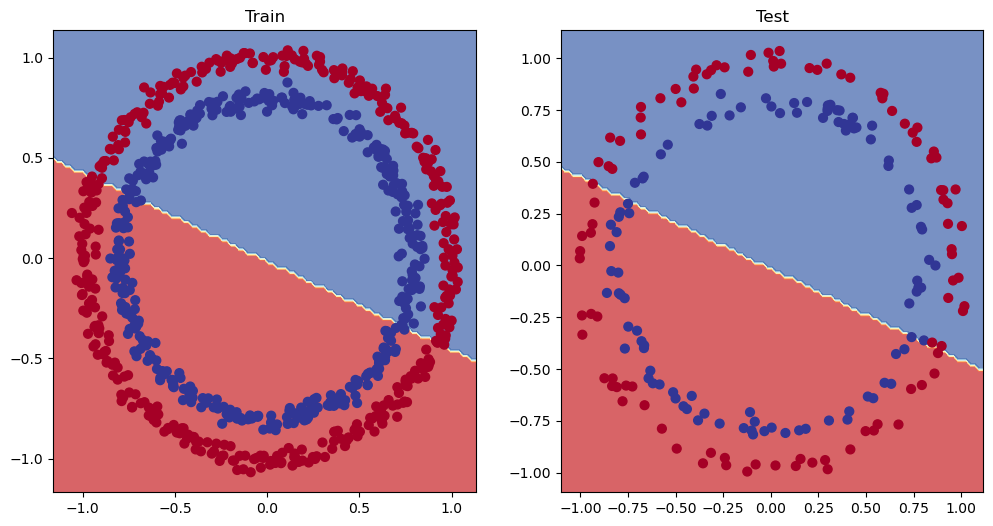

In [28]:
# Plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model0, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model0, X=X_test, y=y_test)

In [29]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

model1 = CircleModelV1().to(device)
model1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [30]:
#Setup loss function and optimizer

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(model0.parameters(), lr=0.1)

In [31]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set epochs

epochs = 1000

# Put data on the device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loops
for epoch in range(epochs):
    # Set model to training mode
    model1.train()

    # Forward pass
    y_logits = model1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Calculate loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy(y_train, y_pred)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Optimizer step
    optimizer.step()

    #Testing
    model1.eval()
    with torch.inference_mode():
        test_logits = model1(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        # Loss
        test_loss = loss_fn(test_logits, y_test)

        # Accuracy
        test_acc = accuracy(y_test, test_preds)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Train Loss: {loss:.4f}, Train Acc: {acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")


Epoch 0: Train Loss: 0.6940, Train Acc: 50.88%, Test Loss: 0.6926, Test Acc: 51.00%
Epoch 100: Train Loss: 0.6940, Train Acc: 50.88%, Test Loss: 0.6926, Test Acc: 51.00%
Epoch 200: Train Loss: 0.6940, Train Acc: 50.88%, Test Loss: 0.6926, Test Acc: 51.00%
Epoch 300: Train Loss: 0.6940, Train Acc: 50.88%, Test Loss: 0.6926, Test Acc: 51.00%
Epoch 400: Train Loss: 0.6940, Train Acc: 50.88%, Test Loss: 0.6926, Test Acc: 51.00%
Epoch 500: Train Loss: 0.6940, Train Acc: 50.88%, Test Loss: 0.6926, Test Acc: 51.00%
Epoch 600: Train Loss: 0.6940, Train Acc: 50.88%, Test Loss: 0.6926, Test Acc: 51.00%
Epoch 700: Train Loss: 0.6940, Train Acc: 50.88%, Test Loss: 0.6926, Test Acc: 51.00%
Epoch 800: Train Loss: 0.6940, Train Acc: 50.88%, Test Loss: 0.6926, Test Acc: 51.00%
Epoch 900: Train Loss: 0.6940, Train Acc: 50.88%, Test Loss: 0.6926, Test Acc: 51.00%


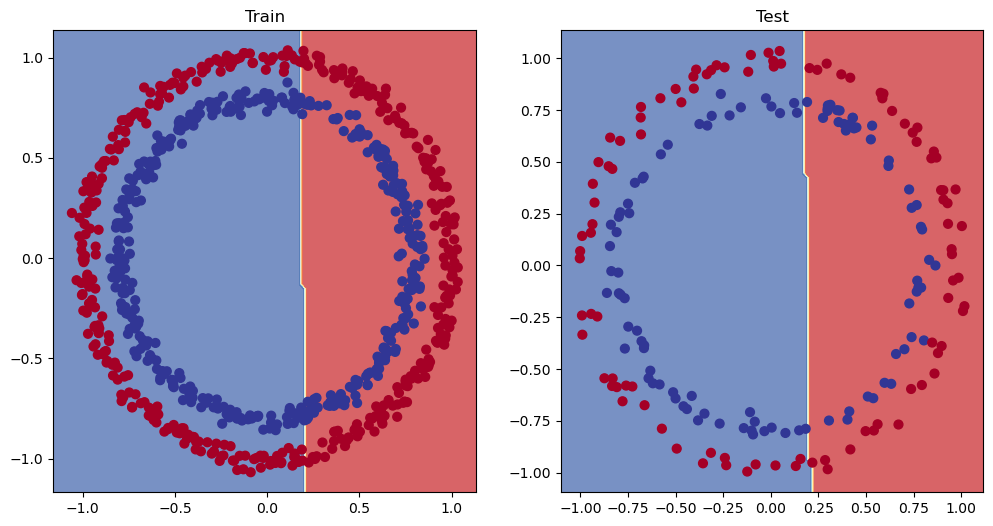

In [32]:
# Plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model1, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model1, X=X_test, y=y_test)

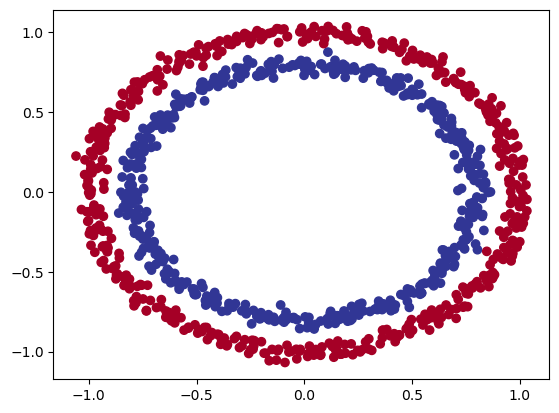

In [33]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [34]:
# Convert data to tensors
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [36]:
# Build non-linear model
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


model3 = CircleModelV2().to(device)
model3        

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [37]:
# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model3.parameters(), lr=0.1)

In [38]:
# Training a model with non-linear activations

torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
    # Set model to training mode
    model3.train()

    # Forward pass
    y_logits = model3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Calculate loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy(y_train, y_pred)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Optimizer step
    optimizer.step()

    #Testing
    model3.eval()
    with torch.inference_mode():
        test_logits = model3(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        # Loss
        test_loss = loss_fn(test_logits, y_test)

        # Accuracy
        test_acc = accuracy(y_test, test_preds)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Train Loss: {loss:.4f}, Train Acc: {acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch 0: Train Loss: 0.6929, Train Acc: 50.00%, Test Loss: 0.6932, Test Acc: 50.00%
Epoch 100: Train Loss: 0.6912, Train Acc: 52.88%, Test Loss: 0.6910, Test Acc: 52.50%
Epoch 200: Train Loss: 0.6898, Train Acc: 53.37%, Test Loss: 0.6894, Test Acc: 55.00%
Epoch 300: Train Loss: 0.6879, Train Acc: 53.00%, Test Loss: 0.6872, Test Acc: 56.00%
Epoch 400: Train Loss: 0.6852, Train Acc: 52.75%, Test Loss: 0.6841, Test Acc: 56.50%
Epoch 500: Train Loss: 0.6810, Train Acc: 52.75%, Test Loss: 0.6794, Test Acc: 56.50%
Epoch 600: Train Loss: 0.6751, Train Acc: 54.50%, Test Loss: 0.6729, Test Acc: 56.00%
Epoch 700: Train Loss: 0.6666, Train Acc: 58.38%, Test Loss: 0.6632, Test Acc: 59.00%
Epoch 800: Train Loss: 0.6516, Train Acc: 64.00%, Test Loss: 0.6476, Test Acc: 67.50%
Epoch 900: Train Loss: 0.6236, Train Acc: 74.00%, Test Loss: 0.6215, Test Acc: 79.00%


In [39]:
# Make predictions
model3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model3(X_test).squeeze()))

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

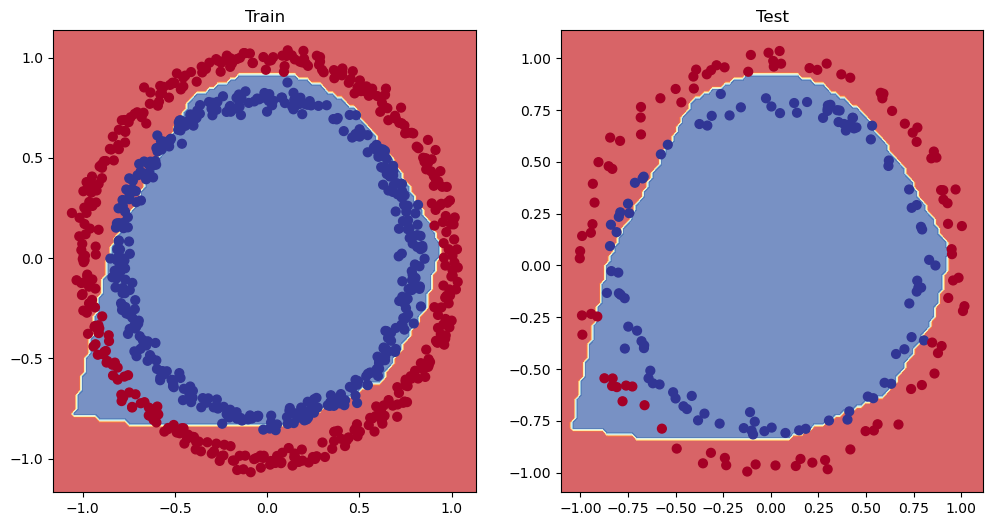

In [40]:
# Plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model3, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model3, X=X_test, y=y_test)


# Creating a toy multi-class dataset

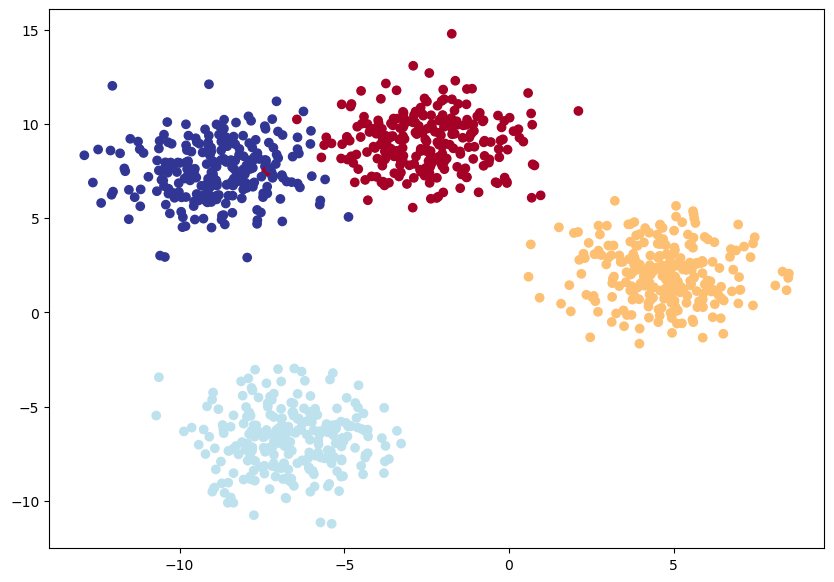

In [46]:
# Import dependencies
import torch
from torch import nn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data generation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# Generate data
X_blob, y_blob = make_blobs(n_samples=1000, centers=NUM_CLASSES, n_features=NUM_FEATURES, cluster_std=1.5,random_state=RANDOM_SEED)

# Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# Train test split
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

# Plot the data
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

# Build a model, multi-class classification

In [42]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [48]:
# Build a model

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes multi-class classification model

        Args:
            input_features (int): Number of input features
            output_features (int): Number of output features
            hidden_units (int): Number of hidden units

        Returns:

        Example:
        
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(input_features, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_features)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)

# Instantiate the model and move it to the device
model4 = BlobModel(input_features=NUM_FEATURES, output_features=NUM_CLASSES).to(device)
model4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [49]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model4.parameters(), lr=0.1)

# Move data to device
X_blob_train, X_blob_test, y_blob_train, y_blob_test = X_blob_train.to(device), X_blob_test.to(device), y_blob_train.to(device), y_blob_test.to(device)

In [52]:
# Create a training and testing loop

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
    # Set model to training mode
    model4.train()

    #Forward pass
    y_logits = model4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # Calculate loss
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy(y_blob_train, y_pred)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Testing
    model4.eval()
    with torch.inference_mode():
        test_logits = model4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        # Loss
        test_loss = loss_fn(test_logits, y_blob_test)
        acc = accuracy(y_blob_test, test_preds)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Train Loss: {loss:.4f}, Train Acc: {acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch 0: Train Loss: 0.0205, Train Acc: 99.50%, Test Loss: 0.0092, Test Acc: 86.50%
Epoch 100: Train Loss: 0.0203, Train Acc: 99.50%, Test Loss: 0.0091, Test Acc: 86.50%
Epoch 200: Train Loss: 0.0202, Train Acc: 99.50%, Test Loss: 0.0089, Test Acc: 86.50%
Epoch 300: Train Loss: 0.0200, Train Acc: 99.50%, Test Loss: 0.0088, Test Acc: 86.50%
Epoch 400: Train Loss: 0.0199, Train Acc: 99.50%, Test Loss: 0.0087, Test Acc: 86.50%
Epoch 500: Train Loss: 0.0197, Train Acc: 99.50%, Test Loss: 0.0085, Test Acc: 86.50%
Epoch 600: Train Loss: 0.0196, Train Acc: 99.50%, Test Loss: 0.0084, Test Acc: 86.50%
Epoch 700: Train Loss: 0.0195, Train Acc: 99.50%, Test Loss: 0.0083, Test Acc: 86.50%
Epoch 800: Train Loss: 0.0193, Train Acc: 99.50%, Test Loss: 0.0081, Test Acc: 86.50%
Epoch 900: Train Loss: 0.0192, Train Acc: 99.50%, Test Loss: 0.0080, Test Acc: 86.50%


In [53]:
# Make predictions
model4.eval()
with torch.inference_mode():
    y_logits = model4(X_blob_test)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

y_preds[:10], y_blob_test[:10]

(tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'))

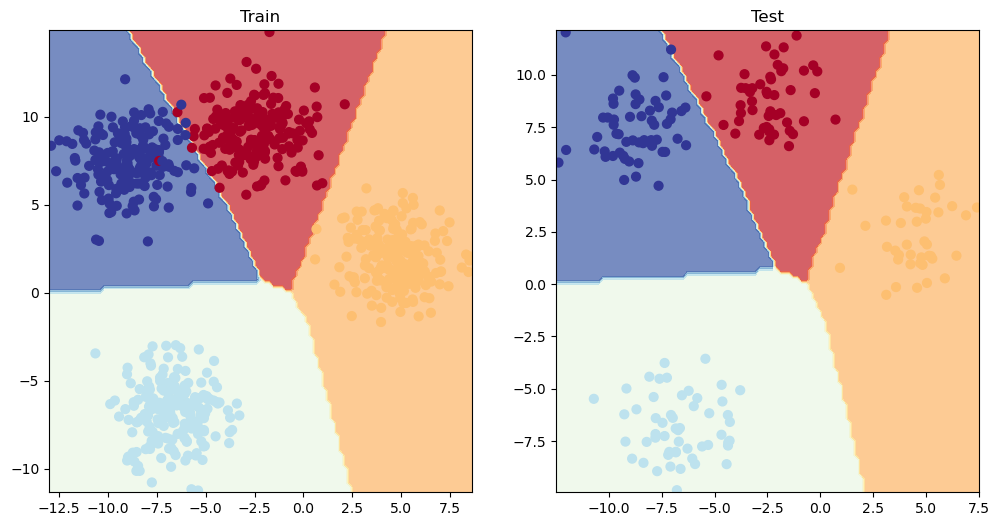

In [54]:
# Plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model4, X=X_blob_train, y=y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model4, X=X_blob_test, y=y_blob_test)

In [59]:
!pip install torchmetrics

   ---------------------------------------- 0.0/172.0 kB ? eta -:--:--
   ------ -------------------------------- 30.7/172.0 kB 660.6 kB/s eta 0:00:01
   ---------------------------- ----------- 122.9/172.0 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 172.0/172.0 kB 1.7 MB/s eta 0:00:00
